## 1. Data Pre-processing

### 1.1 Load Data

In [1]:
pip install fredapi

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install rich

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np

API_KEY = '1vGb0FOsg2hEIGrEhpueLCcWd1Y'
FRED_API_KEY = 'b13a905b98b5dfc1f3910d6a0d875ae3'

rootUrl = 'https://api.glassnode.com'

symbolList = ['BTC', 'ETH', 'LTC', 'AAVE', 'ABT', 'AMPL', 'ANT', 'ARMOR', 'BADGER', 'BAL', 'BAND', 'BAT', 'BIX', 'BNT', 'BOND', 'BRD', 'BUSD', 'BZRX', 'CELR', 'CHSB', 'CND', 'COMP', 'CREAM', 'CRO', 'CRV', 'CVC', 'CVP', 'DAI', 'DDX', 'DENT', 'DGX', 'DHT', 'DMG', 'DODO', 'DOUGH', 'DRGN', 'ELF', 'ENG', 'ENJ', 'EURS', 'FET', 'FTT', 'FUN', 'GNO', 'GUSD', 'HEGIC', 'HOT', 'HPT', 'HT', 'HUSD', 'INDEX', 'KCS', 'LAMB', 'LBA', 'LDO', 'LEO', 'LINK', 'LOOM', 'LRC', 'MANA', 'MATIC',
              'MCB', 'MCO', 'MFT', 'MIR', 'MKR', 'MLN', 'MTA', 'MTL', 'MX', 'NDX', 'NEXO', 'NFTX', 'NMR', 'Nsure', 'OCEAN', 'OKB', 'OMG', 'PAY', 'PERP', 'PICKLE', 'PNK', 'PNT', 'POLY', 'POWR', 'PPT', 'QASH', 'QKC', 'QNT', 'RDN', 'REN', 'REP', 'RLC', 'ROOK', 'RPL', 'RSR', 'SAI', 'SAN', 'SNT', 'SNX', 'STAKE', 'STORJ', 'sUSD', 'SUSHI', 'TEL', 'TOP', 'UBT', 'UMA', 'UNI', 'USDC', 'USDK', 'USDP', 'USDT', 'UTK', 'VERI', 'WaBi', 'WAX', 'WBTC', 'WETH', 'wNXM', 'WTC', 'YAM', 'YFI', 'ZRX']

# symbolListShort = ['BTC', 'ETH', 'LTC']

endPoints = {
    'Price': '/v1/metrics/market/price_usd_close',
    'MarketCap': '/v1/metrics/market/marketcap_usd',
    'ActiveAddress': '/v1/metrics/addresses/active_count',
}

### 1.2 Get Multiple Attributes for Multiple Coins:

In [4]:
def PullData(coin: str,
             feature: str):
    """This Method Pull Data According to Input Parameters(coin, feature)

    Args:
        coin (str): Name of a Coin. Like: "BTC"
        feature (str): Feature of a Coin. Like: "Price"

    Returns:
        data (pd.DataFrame): A DataFrame Contains Date and Feature of One Coin
    """
    import requests

    # Assemble full request url and get responses:
    reqUrl = rootUrl + endPoints[feature]
    res = requests.get(reqUrl,
                       params={'a': coin,
                               'api_key': API_KEY,
                               'i': '1w'})
    data_raw = pd.read_json(res.text,
                            convert_dates=['t'])

    # Rename column "v" according to features
    data = data_raw.rename(columns={"v": f"{feature}",
                                    't': 'Date'})

    # Return a dataframe
    return data

In [5]:
def PullStart(coinList: list):
    """This Method Gets Features(Listed in "endPoints"(Constant)) of Coins(Listed in "coinList"(Method Parameter))

    Args:
        coinList (list): The List of Coins' Name

    Returns:
        fullFrame (pd.DataFrame): A DataFrame Contains All Features of Listed Coin's
    """
    # Initialization
    from functools import reduce
    from fredapi import Fred
    from rich.console import Console
    console = Console()

    colName = ["Date"]
    for key in endPoints.items():
        colName.append(key)
    fullFrame = pd.DataFrame(columns=colName.append("Asset"))

    # Show Welcome
    console.print("Loading [bold magenta]All[/bold magenta] Coins Data")

    # Pull Fred RiskFree
    fred = Fred(api_key=FRED_API_KEY)
    Risk_free_rate = fred.get_series('DGS1MO', frequency = 'wem').to_frame().reset_index().rename(columns={'index': 'Date',
                                                                                        0: 'RiskFree'})
    Risk_free_rate['RiskFree'] = Risk_free_rate['RiskFree'] / 100

    # Init Loop Count
    count = 1
    # Data Pull
    for i in coinList:
        # Preparation for merging
        frameName = f"{i}_Frames"
        locals()[frameName] = []

        # Progress Bar Init
        from rich.progress import (Progress,
                                   TextColumn, 
                                   BarColumn,
                                   TaskProgressColumn, 
                                   TimeElapsedColumn, 
                                   TimeRemainingColumn)

        progress = Progress(TextColumn("[progress.description]{task.description}"), 
                            BarColumn(), 
                            TaskProgressColumn(), 
                            TimeRemainingColumn(compact=True,
                                                elapsed_when_finished=True))
                            #expand=True)
        
        with progress:
                # Get data
            for j in progress.track(endPoints.keys(), description=f"Pulling {i}'s Data, Coins Ramaining: {len(coinList) - count}"):
                locals()[frameName].append(PullData(i,
                                                    j))
        
        # Loop Count + 1
        count += 1 

        # Merge 2-column dataframes to a single dataframe
        dfName = f"{i}_All"
        # Outer Merge Glassnode to Ensure Not Missing Any Values.
        # Left Merge Fred to ensure all the records in api stored.
        locals()[dfName] = reduce(lambda left, right:
                                  pd.merge(left, right,
                                           on='Date',
                                           how='outer'),
                                  locals()[frameName]).merge(Risk_free_rate,
                                                             how='left',
                                                             on='Date').sort_values(by=['Date'])
        locals()[dfName]['Asset'] = i

        # Merge All Coins into a single Dataframe
        fullFrame = pd.concat([fullFrame, locals()[dfName]],
                                     ignore_index=True)

        #print(f"\n{i} data successfully pulled\n")
    console.print('All Frames Merged')
    console.print('\nALL DATA [bold green]SUCCESSFULLY[/bold green] PULLED!')

    return fullFrame

### 1.3 Imputation for NA values using linear interpolation method

If the price for the asset is missing for the latest 4 weeks , then we consider it as a cryto currency that stopped trading, we won't include it in our sample. (this should be done before return calculation)

In [6]:
def InterpolationImpute (sample: pd.DataFrame):
    """This Method will impute NA values using linear interpolation method

    Args:
        sample (pd.DataFrame): The Pulled Data 

    Returns:
        fullFrame (pd.DataFrame): A DataFrame Imputed all NA using linear interpolation
    """
    # Initialization
    imputedFrame = pd.DataFrame(columns=list(sample.columns))
    
    orgcols = list(sample.columns)
    cols = orgcols.copy()
    cols.remove('Date')
    cols.remove('Asset')
    for index in sample['Asset'].unique().tolist():
        syntax = f"Asset == '{index}'"
        segment = sample.query(syntax)

#if the price for the asset is missing for the latest **4 weeks** , 
#then we consider it as a cryto currency that stopped trading, we won't include it in our sample

        if (segment['Price'][-4:].isnull().sum() < 4):
            temp = segment[cols].interpolate(method='linear', limit_direction='forward', axis=0)
            temp['Asset'] = segment['Asset']
            temp['Date'] = segment['Date']
            imputedFrame = pd.concat([imputedFrame, temp[orgcols]],
                                     ignore_index=True)
    

    
    return imputedFrame

### <font color = red> 1.4 Calculate Returns (to be changed)

In [7]:
def AddReturn(sample: pd.DataFrame):
    """This Method Add Return Column to Pulled Raw Data

    Args:
        sample (pd.DataFrame): The Raw Pulled Data without a Return Column

    Returns:
        fullFrame (pd.DataFrame): DataFrame with a Return Column
    """
    fullFrame = pd.DataFrame(columns=list(sample.columns).append(['Return','week2_return','Npast52']))
    for index in sample['Asset'].unique().tolist():
        syntax = f"Asset == '{index}'"
        segment = sample.query(syntax)
        # Only Select 53 Weeks for Test
#         temp = segment[-53:-1].reset_index().drop('index', axis=1)
#         segment = segment[-52:].reset_index().drop('index', axis=1)
        segment = segment.assign(Return = segment.Price.rolling(2).apply(lambda x: (x.iloc[-1]-x.iloc[0])/x.iloc[0]).copy())
        segment = segment.assign(week2_return = segment.Price.rolling(4).apply(lambda x: (x.iloc[-2]-x.iloc[0])/x.iloc[0]))
        segment = segment.assign(Npast52_return = segment.Price.rolling(52).apply(lambda x: (x.iloc[-1]-x.iloc[0])/x.iloc[0]))
        segment = segment[-52:].reset_index(drop=True)
        fullFrame = pd.concat([fullFrame, segment],
                                     ignore_index=True)
        fullFrame["ExcessReturn"] = fullFrame["Return"] - fullFrame["RiskFree"]

    return fullFrame

### 1.5 Initialize 

In [8]:
# Get fullSample Raw Data(Without Return)
fullSample_raw = PullStart(symbolList)

Pulling ZRX's Data, Coins Ramaining: 0 ━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━  67% 00:01

All Frames Merged

ALL DATA SUCCESSFULLY PULLED!

In [9]:
# Impute missing value using interploration method
imputedfullSample = InterpolationImpute(fullSample_raw)
imputedfullSample

,Date,Price,MarketCap,ActiveAddress,RiskFree,Asset
0,2008-12-29,NaN,NaN,0.0,0.0002,BTC
1,2009-01-05,NaN,NaN,0.0,0.0008,BTC
2,2009-01-12,NaN,NaN,34.0,0.0004,BTC
3,2009-01-19,NaN,NaN,63.0,0.0004,BTC
4,2009-01-26,NaN,NaN,61.0,0.0003,BTC
...,...,...,...,...,...,...
22742,2022-03-28,0.910632,7.717570e+08,835.0,0.0017,ZRX
22743,2022-04-04,0.754619,6.395366e+08,1284.0,0.0017,ZRX
22744,2022-04-11,0.686854,5.821057e+08,1266.0,0.0020,ZRX
22745,2022-04-18,0.808817,6.854696e+08,2274.0,0.0031,ZRX


In [10]:
# Add Return to fullSample
fullSample = AddReturn(imputedfullSample)

### 1.6 Get the large capitalization portfolio - largeCapSample 
Use (maket cap > 1m and top 100) to set up the dynamic porfolio for each week, we would use this dynamic portfolio for our factors calculation.

In [11]:
largeCapport = fullSample.query("MarketCap > 1000000")
largeCapSample = largeCapport.groupby(['Date']).apply(lambda x: x.nlargest(100,['MarketCap'])).reset_index(drop=True)

## 2. MKT Factor (Fiona)

### 2.1 Calculate MKT for each week

In [12]:
## largeCapSample is a big dataframe include all crypto currencies makcap greater than 1000000
marketport = largeCapSample.groupby('Date')['MarketCap'].sum().reset_index(name='TotalMarketCap')

marketInd = largeCapSample.copy()
marketInd['weights'] = marketInd['Return'] * marketInd['MarketCap']
recomp = marketInd.groupby('Date')['weights'].sum().reset_index(name='TotalMarketReturn')
marketport['MarketIndexReturn'] = recomp['TotalMarketReturn']/ marketport['TotalMarketCap']

In [13]:
riskfree = largeCapSample.groupby('Date')['RiskFree'].mean().reset_index()
marketport = marketport.merge(riskfree, on='Date')
marketport['MKT'] = marketport['MarketIndexReturn'] - marketport['RiskFree']
MKT_f = marketport[['Date','MKT']]

### 2.2 MKT_f - market factor

In [14]:
MKT_f.head()

,Date,MKT
0,2021-05-03,0.118404
1,2021-05-10,-0.145781
2,2021-05-17,-0.280499
3,2021-05-24,0.069525
4,2021-05-31,0.042021


### <font color='green'> Test for mkt factor
    value weighted return= weight1 * return1 + weight2 * return 2 + ...
    weight1 = cap1/cap_sum,  weight2 = cap2/cap_sum ...
    value weighted return = cap1  * return1/cap_sum  + cap2 * return2/cap_sum + ..
                          = (cap1 * return1 + cap2 * return2 + ...)/cap_sum

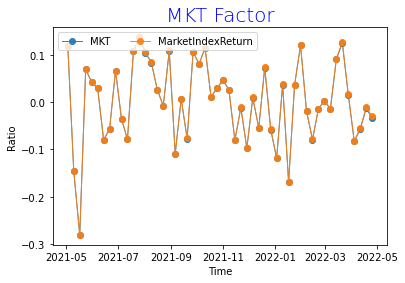

In [15]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

factors = marketport[["Date", "MKT","MarketIndexReturn"]]

palette = plt.get_cmap('Set1')
 
num=0
for column in factors.drop('Date', axis=1):
    num+=1
    plt.plot(factors['Date'], factors[column], marker='o', linewidth=1, alpha=0.9, label=column)


plt.legend(loc=2, ncol=2)
plt.title("MKT Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Ratio")
plt.show()

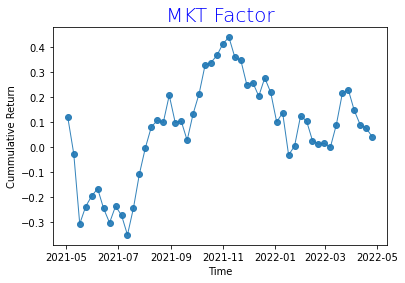

In [16]:
plt.plot(MKT_f.Date, np.cumsum(MKT_f.MKT), marker='o', linewidth=1, alpha=0.9, label=column)
plt.title("MKT Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Cummulative Return")
plt.show()

## 3. SMB Factor (Fiona)

### 3.1 Using quantile method to get the dynamic portfolios for top cap 20%, and bottom cap 20% 

In [17]:
largeCap = largeCapSample.groupby(['Date']).apply(lambda 
                                                x: x.nlargest(round(0.2*len(x)),
                                                              ['MarketCap'])).reset_index(drop=True)

smallCap = largeCapSample.groupby(['Date']).apply(lambda 
                                                x: x.nsmallest(round(0.2*len(x)),
                                                              ['MarketCap'])).reset_index(drop=True)
largeCap.head()

,Date,Price,MarketCap,ActiveAddress,RiskFree,Asset,Return,week2_return,Npast52_return,ExcessReturn
0,2021-05-03,58218.566077,1.088991e+12,6622607.0,0.0001,BTC,0.028357,0.008014,5.020518,0.028257
1,2021-05-03,3932.359246,4.554030e+11,3548128.0,0.0001,ETH,0.331870,0.322830,17.982967,0.331770
2,2021-05-03,1.000026,5.372178e+10,576798.0,0.0001,USDT,0.000035,0.000088,-0.002087,-0.000065
3,2021-05-03,385.704466,2.608153e+10,1438322.0,0.0001,LTC,0.433524,-0.015384,7.838155,0.433424
4,2021-05-03,52.096533,2.182895e+10,65705.0,0.0001,LINK,0.320233,0.015018,12.766384,0.320133


### 3.2 Using equal-weighted average method to get the SMB
SMB = equal-weighted average of returns on small portfolis - equal-weighted average of returns on large portfolis

In [18]:
largeport = largeCap.groupby('Date')['Return'].mean().reset_index(name='LargePortReturn')
smallport = smallCap.groupby('Date')['Return'].mean().reset_index(name='SmallPortReturn')
smallport['SMB'] = smallport['SmallPortReturn'] - largeport['LargePortReturn']
SMB_f = smallport[['Date','SMB']]

In [19]:
SMB_f.head()

,Date,SMB
0,2021-05-03,-0.143667
1,2021-05-10,-0.189053
2,2021-05-17,-0.148497
3,2021-05-24,0.004411
4,2021-05-31,0.029201


### <font color = 'green'> Test SMB

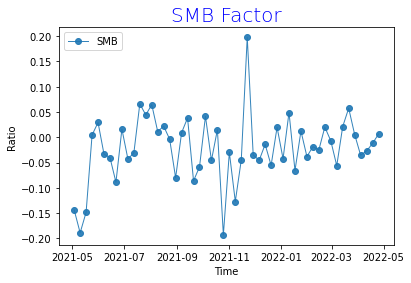

In [20]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

factors = SMB_f

palette = plt.get_cmap('Set1')
 
num=0
for column in factors.drop('Date', axis=1):
    num+=1
    plt.plot(factors['Date'], factors[column], marker='o', linewidth=1, alpha=0.9, label=column)


plt.legend(loc=2, ncol=2)
plt.title("SMB Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Ratio")
plt.show()

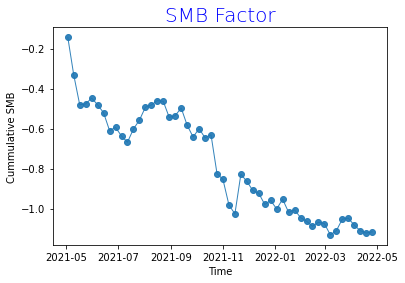

In [21]:
plt.plot(SMB_f.Date, np.cumsum(SMB_f.SMB), marker='o', linewidth=1, alpha=0.9, label=column)
plt.title("SMB Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Cummulative SMB")
plt.show()

In [22]:
from sklearn.linear_model import LinearRegression
performance = {}


factors = SMB_f

features = factors.columns.tolist()
features.remove('Date')
target = "ExcessReturn"

for index in fullSample['Asset'].unique().tolist():
    syntax = f"Asset == '{index}'"
    segment = fullSample.query(syntax)
    
    reg = segment[['Date','ExcessReturn']].merge(factors, on = 'Date', how = 'outer')
    y = reg [target].copy()
    x = reg [features].copy()    
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)    
    alpha = model.intercept_    
    performance[index] = alpha

In [23]:
alp_sig = pd.DataFrame(list(performance.items()), 
                       columns = ['Asset','Alpha'])
alp_sig = alp_sig.sort_values(by=['Alpha'], 
                              ascending = False)
alp_sig.head(10)

,Asset,Alpha
15,BRD,0.195732
112,VERI,0.083878
71,NFTX,0.082342
5,AMPL,0.064211
54,LDO,0.053610
68,MX,0.044315
28,DDX,0.041852
58,LRC,0.041307
87,QNT,0.040772
93,RPL,0.039205


In [24]:
alp_sig.tail(10)

,Asset,Alpha
32,DMG,-0.014985
14,BOND,-0.015631
63,MIR,-0.018728
118,YAM,-0.020562
31,DHT,-0.021591
34,DOUGH,-0.021652
52,LAMB,-0.022139
20,CND,-0.024242
73,Nsure,-0.026052
7,ARMOR,-0.037581


In [25]:
al = alp_sig.head(10).Asset.tolist()
hi = fullSample.query("Asset in @al ")

mk = hi.groupby('Asset')['MarketCap'].mean().reset_index(name = "AverageMarketCap")
mk

,Asset,AverageMarketCap
0,AMPL,1.445432e+08
1,BRD,2.657980e+07
2,DDX,1.063225e+08
3,LDO,1.300025e+08
4,LRC,1.195700e+09
5,MX,2.055389e+08
6,NFTX,5.288922e+07
7,QNT,1.950075e+09
8,RPL,2.945992e+08
9,VERI,1.018901e+08


In [26]:
asm = alp_sig.tail(10).Asset.tolist()
lo = fullSample.query("Asset in @asm ")

ml = lo.groupby('Asset')['MarketCap'].mean().reset_index(name = "AverageMarketCap")
ml

,Asset,AverageMarketCap
0,ARMOR,1.743356e+07
1,BOND,3.827531e+09
2,CND,2.369338e+07
3,DHT,1.481919e+07
4,DMG,2.217906e+06
5,DOUGH,5.848372e+06
6,LAMB,2.159385e+07
7,MIR,2.226654e+08
8,Nsure,1.129428e+06
9,YAM,3.947659e+06


## 4. VAL Factor (Lydia)

**4.1 Reshape to get three tables with: Npast52_return, MarketCap, Return**

In [27]:
value_npast52 = fullSample.loc[:,['Date', 
                                  'Npast52_return', 
                                  'Asset']].pivot(index="Date", 
                                                  columns=["Asset"], 

                                                  values='Npast52_return').reset_index().rename_axis(None, 
                                                                                                     axis=1).sort_values('Date')
#value_npast52.to_csv('value_npast52.csv')
#value_npast52.head()

In [28]:
value_marketcap = fullSample.loc[:,['Date',
                                    'MarketCap',
                                    'Asset']].pivot(index ='Date', 
                                                    columns = ["Asset"],
                                                    values = 'MarketCap'). reset_index().rename_axis(None,
                                                                                                    axis=1).sort_values('Date')
#value_marketcap.head(3)

value_weekreturn = fullSample.loc[:, ['Date',
                                      'Return',
                                      'Asset']].pivot(index='Date',
                                                      columns=['Asset'],
                                                      values ='Return').reset_index().rename_axis(None,
                                                                                                  axis=1).sort_values('Date')
                                                                                   
#value_weekreturn.head(3)

**4.2 Generate two tables to identify whether in a day a coins is top20 or low20 against Npast52:**

In [29]:
value_npast52_temp = value_npast52.copy()
cols_coins = list(fullSample['Asset'].unique())

value_npast52_temp['top20'] = value_npast52[cols_coins].quantile(q=0.8, axis=1, numeric_only=True, interpolation='linear')
value_npast52_temp['low20'] = value_npast52[cols_coins].quantile(q=0.2, axis=1, numeric_only=True, interpolation='linear')

value_npast52_top = value_npast52_temp.drop(columns =['Date','low20'])
value_npast52_low = value_npast52_temp.drop(columns =['Date','top20'])

index_top = value_npast52_top.apply(lambda x: x > value_npast52_top.iloc[:,-1])
index_top = index_top.drop(columns='top20')
index_low = value_npast52_low.apply(lambda x: x < value_npast52_low.iloc[:,-1])
index_low = index_low.drop(columns='low20')
index_low.tail()

,AAVE,ABT,AMPL,ANT,ARMOR,BADGER,BAL,BAND,BAT,BIX,...,VERI,WBTC,WETH,WTC,WaBi,YAM,YFI,ZRX,sUSD,wNXM
47,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,True,True,False,False,False,False
48,False,False,False,False,True,False,False,True,False,True,...,False,False,False,False,True,True,False,False,False,False
49,False,False,False,False,True,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
50,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,True,True,False,False,False,False
51,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,True,True,False,False,False,False


**4.3 Calculate top20 and low20 weighted weekly return:**

In [30]:
sum_top_weight = pd.DataFrame((value_weekreturn.iloc[:,1:].values 
                               * index_top.values 
                               * value_marketcap.iloc[:,1:].values))
sum_top_weight['weight_top_sum'] = sum_top_weight.sum(axis='columns')


sum_top_mktcap_temp = pd.DataFrame((index_top.values 
                               * value_marketcap.iloc[:,1:].values))
sum_top_weight['Totalmktcap_top'] = sum_top_mktcap_temp.sum(axis='columns')
sum_top_weight['ValFactor_top'] = sum_top_weight['weight_top_sum'] / sum_top_weight['Totalmktcap_top']

In [31]:
sum_low_weight = pd.DataFrame((value_weekreturn.iloc[:,1:].values 
                               * index_low.values 
                               * value_marketcap.iloc[:,1:].values))
sum_low_weight['weight_low_sum'] = sum_low_weight.sum(axis='columns')

sum_low_mktcap_temp = pd.DataFrame((index_low.values 
                               * value_marketcap.iloc[:,1:].values))
sum_low_weight['Totalmktcap_low'] = sum_low_mktcap_temp.sum(axis='columns')
sum_low_weight['ValFactor_low'] = sum_low_weight['weight_low_sum'] / sum_low_weight['Totalmktcap_low']

**4.4 Get Value Factor:**

In [32]:
valueFactor = pd.DataFrame(columns=['Date','VAL'])
valueFactor['Date'] = value_weekreturn['Date']
valueFactor['VAL'] = sum_top_weight['ValFactor_top'] - sum_low_weight['ValFactor_low']
valueFactor

,Date,VAL
0,2021-05-03,0.427391
1,2021-05-10,0.165418
2,2021-05-17,-0.409644
3,2021-05-24,0.149525
4,2021-05-31,0.121057
5,2021-06-07,-0.068965
6,2021-06-14,-0.099015
7,2021-06-21,-0.122532
8,2021-06-28,0.164612
9,2021-07-05,-0.073297


**4.5 Factor visualization:**

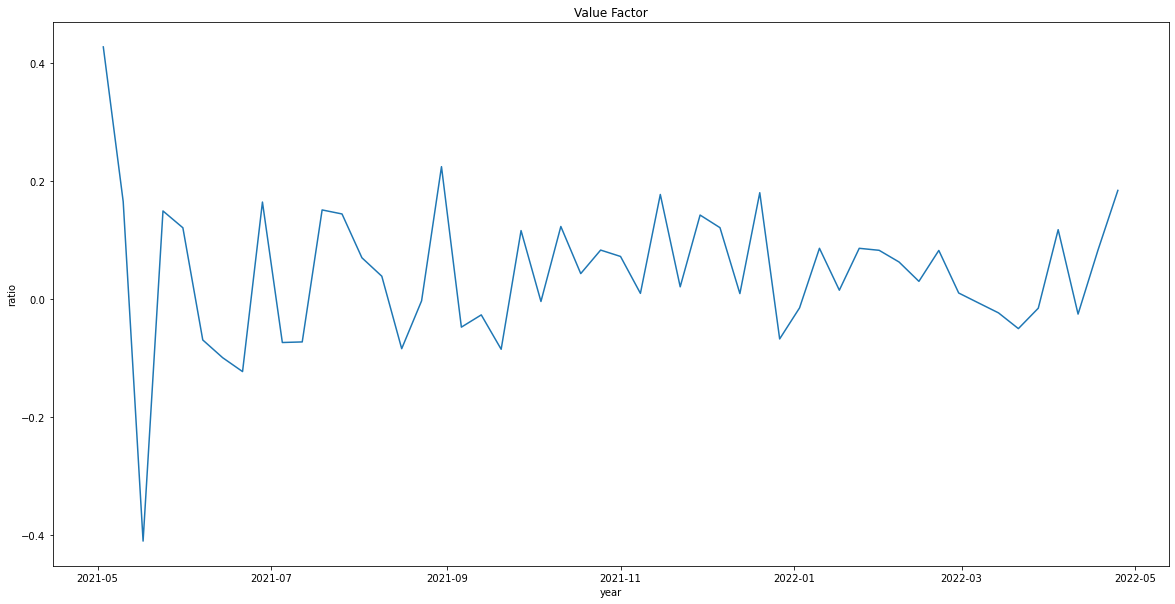

In [33]:
import matplotlib.pyplot as plt

#for i in regr_df.columns.to_list():
plt.figure(figsize = (20,10))
plt.plot(valueFactor.Date, valueFactor.VAL)
plt.ylabel('ratio')
plt.xlabel('year')
plt.title('Value Factor')
plt.show()


## 5. MOM Factor (Sean)

In [34]:
largeCapSample.query("Asset == 'YAM'")

,Date,Price,MarketCap,ActiveAddress,RiskFree,Asset,Return,week2_return,Npast52_return,ExcessReturn


### Reshape Dataframe

In [35]:
# Get Return DataFrame
returnAll = largeCapSample.loc[:, ['Date',
                                   'Return',
                                   'Asset']].pivot(index="Date",
                                                   columns=["Asset"],
                                                   values='Return').reset_index().rename_axis(None,
                                                                                              axis=1).sort_values('Date')
returnAll.head()

,Date,AAVE,ABT,AMPL,ANT,ARMOR,BADGER,BAL,BAND,BAT,...,USDT,UTK,VERI,WBTC,WTC,WaBi,YFI,ZRX,sUSD,wNXM
0,2021-05-03,-0.049263,NaN,0.112456,0.069679,0.080898,-0.024938,0.079109,0.001570,0.126182,...,0.000035,-0.003380,0.406858,0.032826,0.141704,0.070760,0.102180,0.046813,0.010270,0.348608
1,2021-05-10,0.143665,NaN,-0.281857,-0.244447,-0.323333,-0.256346,-0.182583,-0.204940,-0.194722,...,-0.000014,-0.254292,0.062182,-0.204564,-0.164128,-0.319218,0.234226,-0.195655,-0.007335,-0.150428
2,2021-05-17,-0.435925,NaN,-0.357192,-0.560776,-0.456955,-0.597872,-0.523110,-0.514725,-0.504094,...,0.001651,-0.542375,-0.447383,-0.245743,-0.593304,-0.551696,-0.499353,-0.486727,-0.019204,-0.410748
3,2021-05-24,0.094413,NaN,0.464830,0.228098,0.103387,0.117416,0.069808,0.085198,0.244939,...,-0.001657,0.164792,0.188722,0.019047,0.204790,0.212288,0.272157,0.161636,0.005509,0.241871
4,2021-05-31,0.126079,NaN,0.076882,0.345243,-0.040499,0.302944,0.054685,0.090265,0.082609,...,0.000884,0.163088,0.046409,0.005559,-0.025069,0.090076,0.028074,0.128756,0.000937,0.052810


In [36]:
# Get Price DataFrame
capAll = largeCapSample.loc[:, ['Date',
                                'MarketCap',
                                'Asset']].pivot(index="Date",
                                                columns=["Asset"],
                                                values='MarketCap').reset_index().rename_axis(None,
                                                                                              axis=1).sort_values('Date')
capAll.head()

,Date,AAVE,ABT,AMPL,ANT,ARMOR,BADGER,BAL,BAND,BAT,...,USDT,UTK,VERI,WBTC,WTC,WaBi,YFI,ZRX,sUSD,wNXM
0,2021-05-03,5.735887e+09,NaN,2.526164e+08,2.017177e+08,5.443477e+07,3.027644e+08,4.597610e+08,3.617656e+08,2.111519e+09,...,5.372178e+10,3.318752e+08,5.324600e+07,9.906188e+09,1.416346e+08,5.975726e+07,1.951897e+09,1.528303e+09,1.462172e+08,1.973831e+08
1,2021-05-10,6.648981e+09,NaN,1.814148e+08,1.524085e+08,4.557013e+07,2.295646e+08,3.758166e+08,2.876253e+08,1.702456e+09,...,5.737547e+10,2.474819e+08,5.655696e+07,8.084615e+09,1.183883e+08,4.068168e+07,2.409084e+09,1.286737e+09,1.451447e+08,1.676911e+08
2,2021-05-17,3.779533e+09,NaN,1.599928e+08,6.694150e+07,3.158087e+07,9.413106e+07,1.792233e+08,1.395775e+08,8.449776e+08,...,5.861682e+10,1.132538e+08,3.125433e+07,6.288841e+09,4.814811e+07,1.823774e+07,1.206103e+09,6.795007e+08,2.038237e+08,9.881228e+07
3,2021-05-24,4.141262e+09,NaN,1.904880e+08,8.221074e+07,3.862744e+07,1.081680e+08,1.917345e+08,1.514692e+08,1.051984e+09,...,6.078695e+10,1.319171e+08,3.715271e+07,6.548297e+09,5.800838e+07,2.210939e+07,1.534352e+09,7.894613e+08,2.515073e+08,1.227121e+08
4,2021-05-31,4.669538e+09,NaN,1.763299e+08,1.133197e+08,3.765641e+07,1.452830e+08,2.022194e+08,1.651416e+08,1.139018e+09,...,6.196493e+10,1.534312e+08,3.887694e+07,6.682725e+09,5.966491e+07,2.410091e+07,1.577431e+09,8.912247e+08,2.567663e+08,1.291925e+08


### Calculate Momentum Matrix(Cumulative 2 week Return)

In [37]:
def getMomMatrix(largeCapSample: pd.DataFrame):
    """This Method Transform LargeCap Matrix to MOM Matrix

    Args:
        largeCapSample (pd.DataFrame): largeCap Matrix Should Contain Every Coins' Full Data

    Returns:
        momMatrix (pd.DataFrame): The Method Returns a MomMatrix
    """
    momMatrix = largeCapSample.loc[:, ['Date',
                                       'week2_return',
                                       'Asset']].pivot(index="Date",
                                                       columns=["Asset"],
                                                       values='week2_return').reset_index().rename_axis(None,
                                                                                                        axis=1).sort_values('Date')
    return momMatrix

# Effect:
momMatrix = getMomMatrix(largeCapSample)
momMatrix.head()

,Date,AAVE,ABT,AMPL,ANT,ARMOR,BADGER,BAL,BAND,BAT,...,USDT,UTK,VERI,WBTC,WTC,WaBi,YFI,ZRX,sUSD,wNXM
0,2021-05-03,0.265500,NaN,-0.111540,0.082952,-0.199626,-0.086183,0.066897,0.028955,-0.059303,...,0.000088,0.267836,-0.051457,0.004572,-0.082666,0.010295,-0.083688,0.069945,0.005691,0.368697
1,2021-05-10,0.324384,NaN,0.030589,0.304105,0.111860,0.414658,0.383932,0.309461,0.384131,...,0.000057,0.944423,0.340565,0.187350,0.514041,0.650508,0.338622,0.460070,0.006242,0.606434
2,2021-05-17,0.087325,NaN,-0.201097,-0.191801,-0.268592,-0.274891,-0.117918,-0.203692,-0.093110,...,0.000021,-0.256813,0.494340,-0.178453,-0.045682,-0.271046,0.360338,-0.158000,0.002860,0.145739
3,2021-05-24,-0.354887,NaN,-0.538372,-0.668143,-0.632540,-0.700956,-0.610182,-0.614177,-0.600658,...,0.001638,-0.658746,-0.413020,-0.400037,-0.660054,-0.694803,-0.382088,-0.587151,-0.026398,-0.499388
4,2021-05-31,-0.382668,NaN,-0.058396,-0.460589,-0.400811,-0.550656,-0.489819,-0.473380,-0.382628,...,-0.000008,-0.466963,-0.343092,-0.231377,-0.510016,-0.456527,-0.363098,-0.403763,-0.013801,-0.268225


### Calculate MOM Percentile(20%, 80%)

In [38]:
def getMomPt(momMatrix: pd.DataFrame):
    """This Method Calculate 20% and 80% Percentile of MomMatrix

    Args:
        momMatrix (pd.DataFrame): MomMatrix Should Contain All Coins' 2-Week Cumulative Returns

    Returns:
        momPt (pd.DataFrame): momPt Has 3 Columns: Date, MOM30p and MOM70p
    """

    # Only Select Assets(BTC, ETH...) Columns
    col = []
    for colName in momMatrix.columns:
        if colName not in ['Date']:
            col.append(colName)
    momMatrix[col].head()

    momPt = pd.DataFrame(columns=['MOM20p',
                                  'MOM80p'])

    momPt['MOM20p'] = momMatrix[col].quantile(.2, axis=1)
    momPt['MOM80p'] = momMatrix[col].quantile(.8, axis=1)

    return momPt

In [39]:
momPt = getMomPt(momMatrix)
momPt.head()

,MOM20p,MOM80p
0,-0.078197,0.210713
1,0.138521,0.514711
2,-0.246304,0.072608
3,-0.629580,-0.399928
4,-0.457340,-0.241237


### Calculate Momentum portfolio returns

In [40]:
def LMH_MOM(momMatrix: pd.DataFrame,
            returnAll: pd.DataFrame,
            capAll: pd.DataFrame,
            momPt: pd.DataFrame):
    """This Method Takes MomMatrix, ReturnMatrix, CapMatrix and MomPercentileMatrix to Get Low, Medium and High Momentum\nWARNING: These 4 Matrix MUST be in Exactly the Same Shape!

    Args:
        momMatrix (pd.DataFrame): MomMatrix Should Contain All Coins' 2-Week Cumulative Returns
        returnAll (pd.DataFrame): Return Matrix Should Contain Every Coins' Return Data
        capAll (pd.DataFrame):  Captial Matrix Should Contain Every Coins' MarketCap Data
        momPt (pd.DataFrame): Mom Percentile Matrix Should Contain 30 & 70 Percentile Momentum

    Returns:
        momLMH (pd.DataFrame): A DataFrame Contains Date, LowMomentum, MediumMomentum and HighMomentum Returns
    """
    # Initialize DataFrames for Low, Medium and High MOM
    lowMom = pd.DataFrame(columns=['Date',
                                   'LowMomentum'])
    lowMom['Date'] = momMatrix['Date']

    medMom = pd.DataFrame(columns=['Date',
                                   'MedMomentum'])
    medMom['Date'] = momMatrix['Date']

    highMom = pd.DataFrame(columns=['Date',
                                    'HighMomentum'])
    highMom['Date'] = momMatrix['Date']

    # Iterate Through Whole DataFrame to Get Low, Medium and High MOM
    # Iterate Though Rows

    from rich.progress import (Progress,
                                   TextColumn, 
                                   BarColumn,
                                   TaskProgressColumn, 
                                   TimeElapsedColumn, 
                                   TimeRemainingColumn)

    progress = Progress(TextColumn("[progress.description]{task.description}"), 
                            BarColumn(), 
                            TaskProgressColumn(), 
                            TimeRemainingColumn(compact=True,
                                                elapsed_when_finished=True))
                            #expand=True)

    with progress:
            # Get data
        for i in progress.track(range(0, momMatrix.shape[0]), description=f"Calculating Low, Medium and High Momentum Matrix..."):
            # Initialization df Used in Method
            lowMomReturnList = []
            medMomReturnList = []
            highMomReturnList = []

            lowMomCapList = []
            medMomCapList = []
            highMomCapList = []

            # Iterate Through Columns
            for j in range(1, momMatrix.shape[1]):
                if momMatrix.iloc[i, j] < momPt.iloc[i, 0]:
                    lowMomReturnList.append(returnAll.iloc[i, j])
                    lowMomCapList.append(capAll.iloc[i, j])
                elif (momPt.iloc[i, 0] < momMatrix.iloc[i, j]) and (momMatrix.iloc[i, j] < momPt.iloc[i, 1]):
                    medMomReturnList.append(returnAll.iloc[i, j])
                    medMomCapList.append(capAll.iloc[i, j])
                elif momMatrix.iloc[i, j] > momPt.iloc[i, 1]:
                    highMomReturnList.append(returnAll.iloc[i, j])
                    highMomCapList.append(capAll.iloc[i, j])

            # Low MOM
            lowValueWeightedAvgList = []
            lowMomCapSum = sum(lowMomCapList)
            for index in range(0, len(lowMomCapList)):
                lowValueWeightedAvgList.append(
                    (lowMomCapList[index]/lowMomCapSum) * lowMomReturnList[index]
                    )
            lowMom.iloc[i, 1] = sum(lowValueWeightedAvgList)

            # Med MOM
            medValueWeightedAvgList = []
            medMomCapSum = sum(medMomCapList)
            for index in range(0, len(medMomCapList)):
                medValueWeightedAvgList.append(
                    (medMomCapList[index]/medMomCapSum) * medMomReturnList[index]
                    )
            medMom.iloc[i, 1] = sum(medValueWeightedAvgList)

            # High MOM
            highValueWeightedAvgList = []
            highMomCapSum = sum(highMomCapList)
            for index in range(0, len(highMomCapList)):
                highValueWeightedAvgList.append(
                    (highMomCapList[index]/highMomCapSum) * highMomReturnList[index]
                    )
            highMom.iloc[i, 1] = sum(highValueWeightedAvgList)

            # Merge
            from functools import reduce
            momLMH = reduce(lambda left, right:
                            pd.merge(left, right,
                                    on='Date',
                                    how='outer'),
                            [lowMom, medMom, highMom])

        return momLMH

momLMH = LMH_MOM(momMatrix, returnAll, capAll, momPt)

Calculating Low, Medium and High Momentum Matrix... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 00:02

In [41]:
momLMH.head()

,Date,LowMomentum,MedMomentum,HighMomentum
0,2021-05-03,0.045323,0.0414,0.313321
1,2021-05-10,-0.0106024,-0.191916,-0.0819048
2,2021-05-17,-0.507623,-0.233568,-0.411367
3,2021-05-24,0.203186,0.0691054,0.0705019
4,2021-05-31,0.154583,0.118771,0.00221412


### Calculate Momentum Factor

In [42]:
def getMomFactor(momLMH: pd.DataFrame):
    """This Method Takes momLMH Matrix to Calculate Momentum Factor

    Args:
        momLMH (pd.DataFrame): Mom LMH Matrix Should Contain Low, Medium, and High Momentum Returns

    Returns:
        momFactor (pd.DataFrame): A DataFrame Contains a Date Column and a Momentum Factor Column
    """
    momFactor = pd.DataFrame(columns=['Date', 'MOM_LTW'])
    momFactor['Date'] = momLMH['Date']
    momFactor['MOM_LTW'] = momLMH['HighMomentum'] - momLMH['LowMomentum']
    return momFactor

In [43]:
momFactor = getMomFactor(momLMH)
momFactor.head()

,Date,MOM_LTW
0,2021-05-03,0.267998
1,2021-05-10,-0.0713024
2,2021-05-17,0.0962568
3,2021-05-24,-0.132685
4,2021-05-31,-0.152368


Text(0, 0.5, 'Cumulative Return')

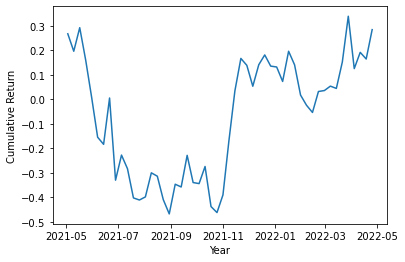

In [44]:
import matplotlib.pyplot as plt

plt.plot(momFactor.Date, np.cumsum(momFactor.MOM_LTW))
plt.xlabel('Year')
plt.ylabel('Cumulative Return')

## 6. NET Factor (Zachary)

The network factor (NET) is constructed by splitting the coins of the Core Sample into 3 groups due to the limitation of available coins. Particularly, each week we split the cryptocurrencies into three [30% 40% 30%] groups by the growth rate in total addresses with balance. The network factor (NET) is the return difference between the top and the bottom network portfolios. 

### Get Address Growth

In [70]:
Address = largeCapSample.loc[:,['Date', 'ActiveAddress', 'Asset']] \
                    .pivot(index = 'Date', columns = 'Asset', values = 'ActiveAddress')\
                    .reset_index() \
                    .rename_axis(None, axis = 1)

copy1 = Address.copy()
copy2 = copy1.shift()

Growth = copy1.copy()
for i in largeCapSample.Asset.unique():
    Growth[i] = np.log(copy1[i]) - np.log(copy2[i])

Growth['20Percentile'] = Growth.quantile(q=0.2, numeric_only = True, axis = 1)
Growth['80Percentile'] = Growth.quantile(q=0.8, numeric_only = True, axis = 1)

### Construct Network factor

In [46]:
Return = fullSample.loc[:,['Date', 'Return', 'Asset']] \
                    .pivot(index = 'Date', columns = 'Asset', values = 'Return')\
                    .reset_index() \
                    .rename_axis(None, axis = 1)

Marketcap = fullSample.loc[:,['Date', 'MarketCap', 'Asset']] \
                    .pivot(index = 'Date', columns = 'Asset', values = 'MarketCap')\
                    .reset_index() \
                    .rename_axis(None, axis = 1)

weight = Marketcap.copy()
weight['total_weight'] = Marketcap.sum(axis = 1, numeric_only=True)
weight[fullSample.Asset.unique()] = weight[fullSample.Asset.unique()].apply(lambda x: x/weight['total_weight'])
weight.drop(columns=['total_weight'])

Weighted_Return = Return.copy()
for i in fullSample.Asset.unique():
    Weighted_Return[i] = weight[i] * Return[i]

In [72]:
Return = largeCapSample.loc[:,['Date', 'Return', 'Asset']] \
                    .pivot(index = 'Date', columns = 'Asset', values = 'Return')\
                    .reset_index() \
                    .rename_axis(None, axis = 1)

NET = pd.DataFrame({'Date':[]})
NET['Date'] = Return.Date
NET['long'] = Return[Growth[largeCapSample.Asset.unique()].apply(lambda x: x >= Growth['80Percentile'])].mean(axis=1, numeric_only= True)
NET['short'] = Return[Growth[largeCapSample.Asset.unique()].apply(lambda x: x <= Growth['20Percentile'])].mean(axis=1, numeric_only= True)
NET.fillna(value = 0, inplace=True)
NET['NET'] = NET.long - NET.short
NET.drop(columns=['short', 'long'], inplace=True)

### Verification

Text(0, 0.5, 'Cumulative Return')

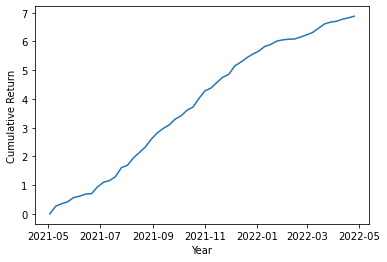

In [73]:
import matplotlib.pyplot as plt

plt.plot(NET.Date, np.cumsum(NET.NET))
plt.xlabel('Year')
plt.ylabel('Cumulative Return')

## 7.Regression Output
### 7.1 Output a list of alphas for all the crypto currencies using factors
Note: Only pick the top 100 cypto currencies from the latest week and check their alphas.

In [49]:
from sklearn.linear_model import LinearRegression

performance = {}

## find the top 100 cypto currencies at the last week

latest = largeCapSample.Date.max()
latestLarge = largeCapSample.query("Date == @latest")

# factors = factors.merge(MOM_f, on = 'Date', how ='outer')
factors = MKT_f.merge(SMB_f, on = 'Date', how = 'outer')

# VAL Added
factors = factors.merge(valueFactor, on = 'Date', how = 'outer')

# MOM Added
factors = factors.merge(momFactor, on = 'Date', how ='outer')

# NET added
factors = factors.merge(NET, on = 'Date', how ='outer')

features = factors.columns.tolist()
features.remove('Date')
target = "ExcessReturn"

for index in latestLarge['Asset'].tolist():
    syntax = f"Asset == '{index}'"
    segment = fullSample.query(syntax)
    
    reg = segment[['Date','ExcessReturn']].merge(factors, on = 'Date', how = 'outer')
    y = reg [target].copy()
    x = reg [features].copy()    
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)    
    alpha = model.intercept_    
    performance[index] = alpha

In [50]:
factors

,Date,MKT,SMB,VAL,MOM_LTW,NET
0,2021-05-03,0.118404,-0.143667,0.427391,0.267998,0.000000
1,2021-05-10,-0.145781,-0.189053,0.165418,-0.0713024,0.234057
2,2021-05-17,-0.280499,-0.148497,-0.409644,0.0962568,0.072054
3,2021-05-24,0.069525,0.004411,0.149525,-0.132685,0.041634
4,2021-05-31,0.042021,0.029201,0.121057,-0.152368,0.143718
5,2021-06-07,0.029528,-0.033515,-0.068965,-0.162286,0.099731
6,2021-06-14,-0.079382,-0.040202,-0.099015,-0.0290471,0.135050
7,2021-06-21,-0.057400,-0.088904,-0.122532,0.189155,0.022996
8,2021-06-28,0.066367,0.016105,0.164612,-0.335509,0.209327
9,2021-07-05,-0.036054,-0.042806,-0.073297,0.102494,0.153346


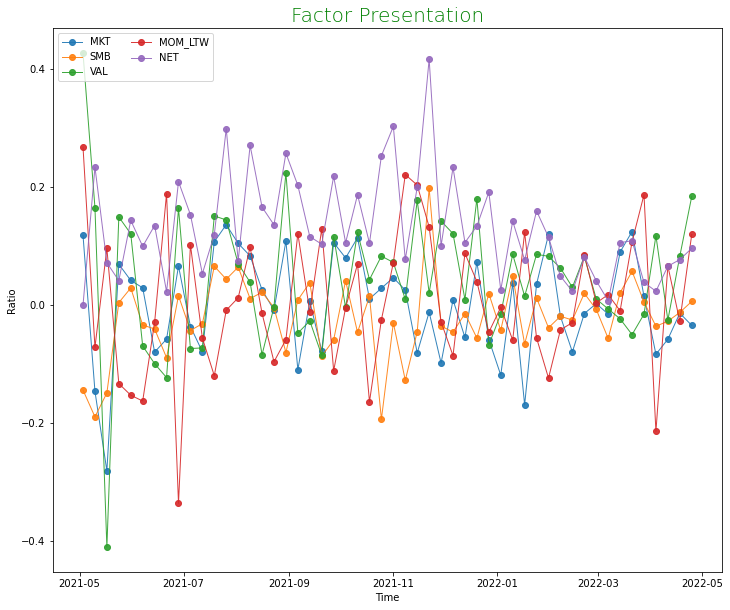

In [51]:
from matplotlib.pyplot import figure

plt.figure(figsize=(12,10))

palette = plt.get_cmap('Set1')
 
num=0
for column in factors.drop('Date', axis=1):
    num+=1
    plt.plot(factors['Date'], factors[column], marker='o',  linewidth=1, alpha=0.9, label=column)


plt.legend(loc=2, ncol=2)
plt.title("Factor Presentation", loc='center', fontsize=20, fontweight=0, color='green')
plt.xlabel("Time")
plt.ylabel("Ratio")
plt.show()

### 7.2 Currently using values (not abs value) of alpha to sort all the crypto currencies

In [52]:
alp_sig = pd.DataFrame(list(performance.items()), 
                       columns = ['Asset','Alpha'])
alp_sig = alp_sig.sort_values(by=['Alpha'], 
                              ascending = False)
alp_sig.head(10)

,Asset,Alpha
72,AMPL,0.093768
46,TEL,0.093183
27,LDO,0.059094
92,SAN,0.051252
90,CREAM,0.047238
69,BADGER,0.042537
82,NFTX,0.042038
60,REP,0.027951
84,PNK,0.022758
67,MLN,0.022064
